--- Running Quick Simulation ---


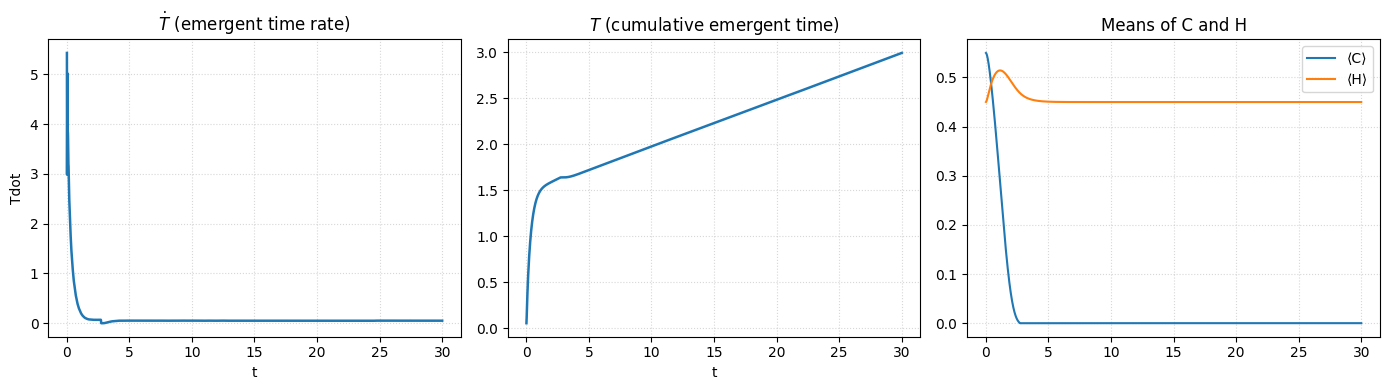

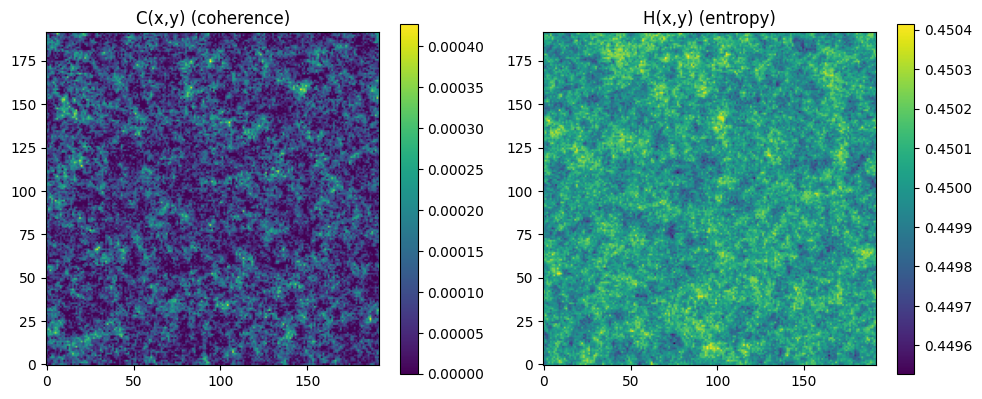

Tdot (original last step) = 0.0504

--- Running Controls & Falsification ---
Tdot (homogenized) ≈ 0.000e+00 (should be ~0)
Tdot (pixel-shuffled) = 0.0617
Tdot (phase-scrambled) = 0.0952
Tdot (block-shuffle+blur) = 0.0207 | original = 0.0504 | Δ = -0.0297

--- Running Parameter Scan for sigmaC ---


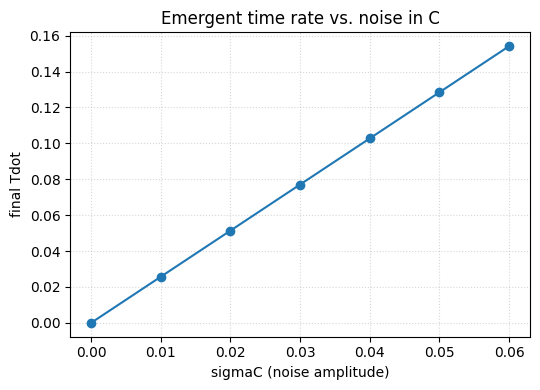


--- Running Multi-seed Statistics (20 seeds) ---

Multi-seed summary (mean ± 95% CI, Cohen's d vs Original):
Original  : 0.0511 ± 0.0003  (n=20, d=+0.00)
Pixel     : 0.0620 ± 0.0004  (n=20, d=+12.86)
Phase     : 0.0695 ± 0.0104  (n=20, d=+1.09)
BlockBlur : 0.0205 ± 0.0002  (n=20, d=-57.30)


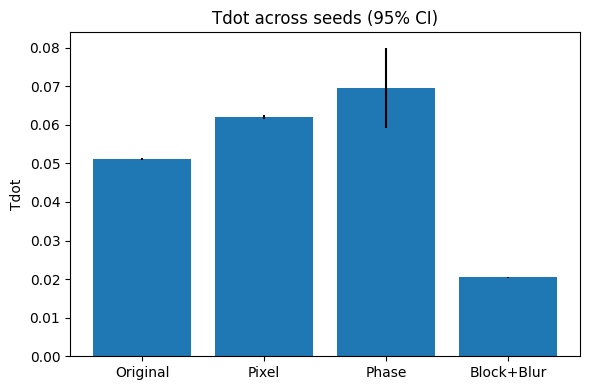


--- Plotting Gradient and Contribution Maps ---


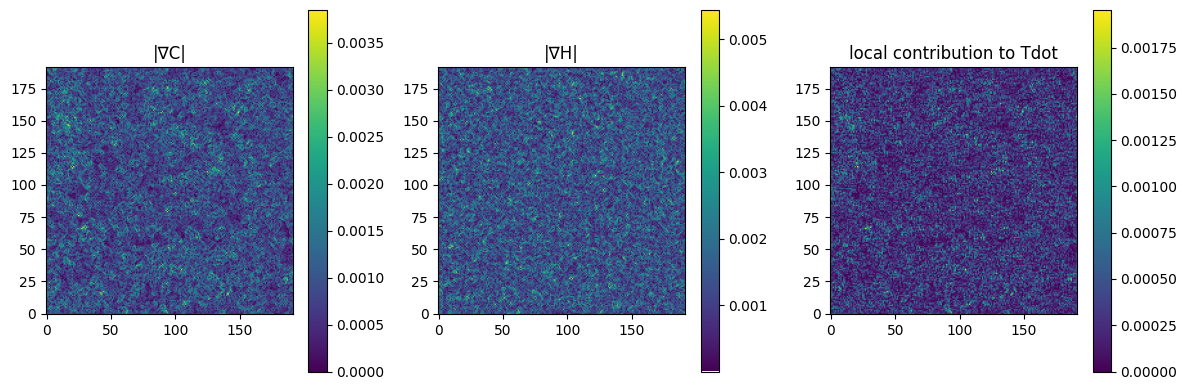


--- Saving Snapshot ---
Saved spanda_last_snapshot.npz with C,H,dx,t

--- Running Pattern-Forming Demo ---


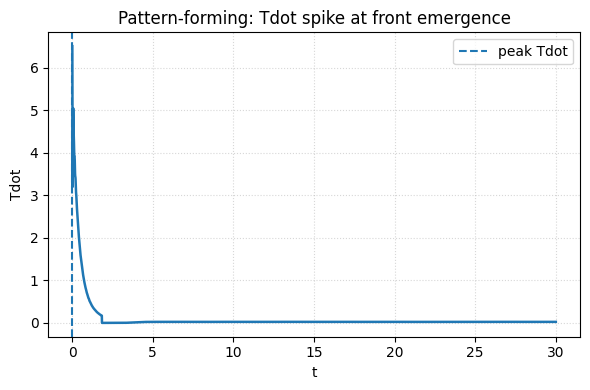

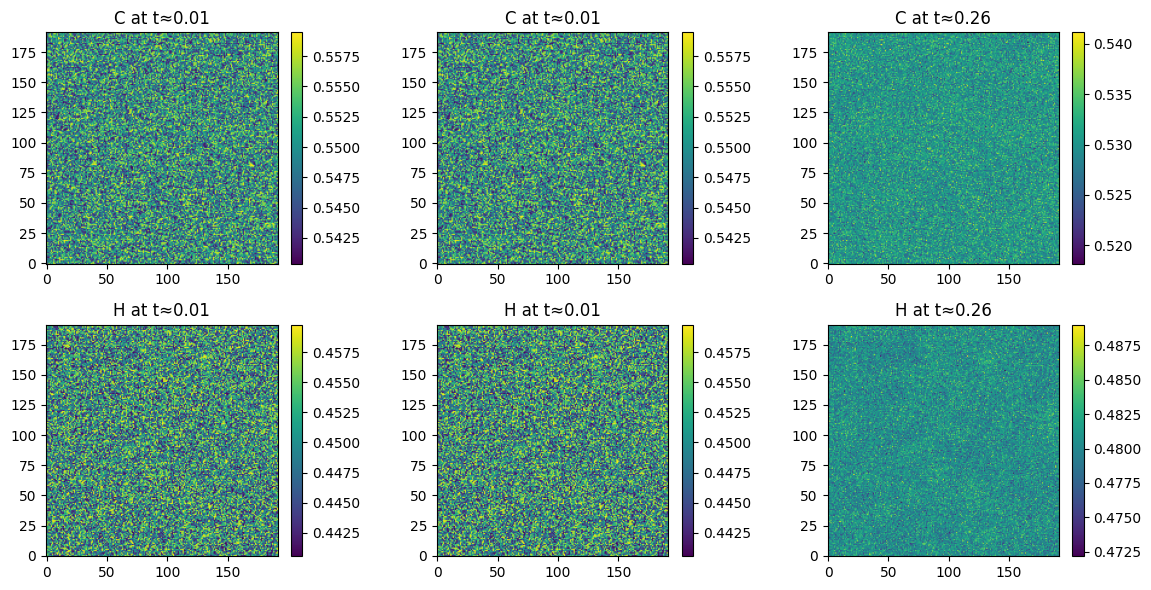

Peak Tdot = 6.5019 at t≈0.010


In [ ]:
# Spanda-PDE Testbench (CLEAN FULL VERSION)
#
# Самодостатній скрипт для моделювання зв'язаних полів C(x,t) та H(x,t), обчислення
# емерджентної часової швидкості Tdot = ||(1-H)∇C - C∇H||_{L1}, валідації за допомогою контролів,
# та демонстрації спайку, що формує патерн.
#
# --- Section 0: Dependencies ---
# Перед запуском переконайтеся, що у вас встановлені ці бібліотеки:
# pip install numpy matplotlib scipy

# --- Section 1: Imports & Utilities ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2
from scipy.ndimage import gaussian_filter
from dataclasses import dataclass
import math

# Фіксація початкових значень для відтворюваності
np.random.seed(42)

# ---------- Numerical helpers ----------

def make_grid(n: int, L: float):
    """Повертає масиви координат та крок сітки (періодична область [0,L))."""
    x = np.linspace(0.0, L, n, endpoint=False)
    y = np.linspace(0.0, L, n, endpoint=False)
    dx = L / n
    return x, y, dx


def laplacian_periodic(u: np.ndarray, dx: float) -> np.ndarray:
    """2D Лапласіан з періодичними ГУ через скінченні різниці."""
    return (
        np.roll(u, 1, 0) + np.roll(u, -1, 0) + np.roll(u, 1, 1) + np.roll(u, -1, 1) - 4.0 * u
    ) / (dx * dx)


def gradients_periodic(u: np.ndarray, dx: float):
    """Центровані періодичні градієнти (ux, uy)."""
    ux = (np.roll(u, -1, 1) - np.roll(u, 1, 1)) / (2.0 * dx)
    uy = (np.roll(u, -1, 0) - np.roll(u, 1, 0)) / (2.0 * dx)
    return ux, uy


def compute_Tdot(C: np.ndarray, H: np.ndarray, dx: float) -> float:
    """Tdot = || (1-H)∇C − C∇H ||_L1 * dx^2 (дискретна L1 по області)."""
    Cx, Cy = gradients_periodic(C, dx)
    Hx, Hy = gradients_periodic(H, dx)
    Vx = (1.0 - H) * Cx - C * Hx
    Vy = (1.0 - H) * Cy - C * Hy
    mag = np.sqrt(Vx * Vx + Vy * Vy)
    return float(np.sum(mag) * (dx * dx))


# --- Section 2: Model Definition (C&H with optional inertia) ---
@dataclass
class Params:
    # grid
    n: int = 256
    L: float = 10.0
    # time
    dt: float = 0.01
    steps: int = 4000
    save_every: int = 50
    # diffusion
    DC: float = 0.35
    DH: float = 0.25
    # inertia & damping (встановіть beta=0 для чисто релаксаційної динаміки)
    betaC: float = 0.2
    betaH: float = 0.1
    alphaC: float = 1.0
    alphaH: float = 1.2
    # nonlinearities
    aC: float = 3.0
    Cstar: float = 0.6
    eta: float = 0.8
    aH: float = 1.5
    H0: float = 0.45
    chi: float = 0.6
    # noise amplitudes
    sigmaC: float = 0.02
    sigmaH: float = 0.02
    # RNG
    seed: int = 123


class SpandaPDE:
    """Симулятор зв'язаних (C,H) з опціональною інерцією, періодичними ГУ, явним крокуванням."""
    def __init__(self, p: Params):
        self.p = p
        np.random.seed(p.seed)
        self.x, self.y, self.dx = make_grid(p.n, p.L)
        # fields
        self.C = 0.55 + 0.02 * (np.random.rand(p.n, p.n) - 0.5)
        self.H = 0.45 + 0.02 * (np.random.rand(p.n, p.n) - 0.5)
        # velocities for inertial form (ігноруються якщо beta=0)
        self.Ct = np.zeros_like(self.C)
        self.Ht = np.zeros_like(self.H)
        # logs
        self.t = 0.0
        self.history = {"t": [], "Tdot": [], "T": [], "C_mean": [], "H_mean": []}
        self.T_accum = 0.0

    # Нелінійні члени
    def reaction_C(self, C, H):
        p = self.p
        return p.aC * C * (1.0 - C) * (C - p.Cstar) - p.eta * C * H

    def reaction_H(self, C, H):
        p = self.p
        return p.aH * (p.H0 - H) + p.chi * C * H

    def step(self):
        p = self.p
        dx = self.dx
        # Лапласіани
        LC = laplacian_periodic(self.C, dx)
        LH = laplacian_periodic(self.H, dx)
        # Реакції
        RC = self.reaction_C(self.C, self.H)
        RH = self.reaction_H(self.C, self.H)
        # Шум
        nC = p.sigmaC * np.random.randn(p.n, p.n)
        nH = p.sigmaH * np.random.randn(p.n, p.n)

        # Інерційна форма: beta*C̈ + alpha*Ċ = D∇²C + R + шум (просте явне оновлення)
        if p.betaC > 0:
            AC = (p.DC * LC + RC + nC - p.alphaC * self.Ct) / max(p.betaC, 1e-12)
            self.Ct = self.Ct + p.dt * AC
            self.C = self.C + p.dt * self.Ct
        else:
            self.C = self.C + p.dt * (p.DC * LC + RC + nC)

        if p.betaH > 0:
            AH = (p.DH * LH + RH + nH - p.alphaH * self.Ht) / max(p.betaH, 1e-12)
            self.Ht = self.Ht + p.dt * AH
            self.H = self.H + p.dt * self.Ht
        else:
            self.H = self.H + p.dt * (p.DH * LH + RH + nH)

        # Обмеження в [0,1]
        np.clip(self.C, 0.0, 1.0, out=self.C)
        np.clip(self.H, 0.0, 1.0, out=self.H)

        # Час та метрики
        self.t += p.dt
        Tdot = compute_Tdot(self.C, self.H, dx)
        self.T_accum += Tdot * p.dt
        self.history["t"].append(self.t)
        self.history["Tdot"].append(Tdot)
        self.history["T"].append(self.T_accum)
        self.history["C_mean"].append(float(np.mean(self.C)))
        self.history["H_mean"].append(float(np.mean(self.H)))

    def run(self, callback=None):
        p = self.p
        snapshots = []
        for it in range(p.steps):
            self.step()
            if (it % p.save_every) == 0:
                snapshots.append((self.t, self.C.copy(), self.H.copy()))
                if callback is not None:
                    callback(self, it)
        return snapshots


# --- Section 3: Quick Simulation & Plots ---
print("--- Running Quick Simulation ---")
# Базові параметри
p = Params(
    n=192, L=10.0, dt=0.01, steps=3000, save_every=50,
    DC=0.35, DH=0.25,
    betaC=0.2, betaH=0.1, alphaC=1.0, alphaH=1.2,
    aC=3.0, Cstar=0.6, eta=0.8,
    aH=1.5, H0=0.45, chi=0.6,
    sigmaC=0.02, sigmaH=0.02, seed=123
)

sim = SpandaPDE(p)
snaps = sim.run()

# Графіки метрик
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].plot(sim.history["t"], sim.history["Tdot"], lw=1.8)
ax[0].set_title(r"$\dot T$ (emergent time rate)")
ax[0].set_xlabel("t"); ax[0].set_ylabel("Tdot")
ax[1].plot(sim.history["t"], sim.history["T"], lw=1.8)
ax[1].set_title("$T$ (cumulative emergent time)")
ax[1].set_xlabel("t")
ax[2].plot(sim.history["t"], sim.history["C_mean"], label="⟨C⟩")
ax[2].plot(sim.history["t"], sim.history["H_mean"], label="⟨H⟩")
ax[2].set_title("Means of C and H"); ax[2].legend()
for a in ax: a.grid(True, ls=":", alpha=0.5)
plt.tight_layout(); plt.show()

# Поля останнього знімку
_, C_last, H_last = snaps[-1]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
im0 = ax[0].imshow(C_last, origin="lower", aspect="equal"); ax[0].set_title("C(x,y) (coherence)")
plt.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(H_last, origin="lower", aspect="equal"); ax[1].set_title("H(x,y) (entropy)")
plt.colorbar(im1, ax=ax[1])
plt.tight_layout(); plt.show()

# Вивід оригінального фінального Tdot
Tdot_original = sim.history["Tdot"][-1]
print(f"Tdot (original last step) = {Tdot_original:.4f}")

# --- Section 4: Controls & Falsification Routines ---
print("\n--- Running Controls & Falsification ---")
# Гомогенізація (Tdot≈0), перемішування пікселів / скремблювання фаз (може підвищити градієнти високих частот),
# та гладкий сурогат (перемішування блоків + Гаусове розмиття), що має знизити Tdot.

# Контроль гомогенізації
C_hom = np.full_like(C_last, np.mean(C_last))
H_hom = np.full_like(H_last, np.mean(H_last))
Tdot_hom = compute_Tdot(C_hom, H_hom, sim.dx)
print(f"Tdot (homogenized) ≈ {Tdot_hom:.3e} (should be ~0)")

# Контроль перемішування пікселів
rng = np.random.default_rng(7)
C_shuf = C_last.flatten().copy(); rng.shuffle(C_shuf); C_shuf = C_shuf.reshape(C_last.shape)
H_shuf = H_last.flatten().copy(); rng.shuffle(H_shuf); H_shuf = H_shuf.reshape(H_last.shape)
Tdot_shuf = compute_Tdot(C_shuf, H_shuf, sim.dx)
print(f"Tdot (pixel-shuffled) = {Tdot_shuf:.4f}")

# Контроль скремблювання фаз
def phase_scramble(u: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    U = fft2(u); amp = np.abs(U); rand_ph = rng.uniform(-np.pi, np.pi, size=u.shape)
    return np.real(ifft2(amp * np.exp(1j * rand_ph)))

C_ps = phase_scramble(C_last, rng); H_ps = phase_scramble(H_last, rng)
Tdot_ps = compute_Tdot(C_ps, H_ps, sim.dx)
print(f"Tdot (phase-scrambled) = {Tdot_ps:.4f}")

# Перемішування блоків + Гаусове розмиття (гладкий сурогат)
def block_shuffle(u: np.ndarray, block: int = 16, rng: np.random.Generator = None) -> np.ndarray:
    """Перемішує непересічні блоки для руйнування великомасштабної структури, контролюючи градієнти."""
    if rng is None:
        rng = np.random.default_rng(0)
    n = u.shape[0]
    assert n % block == 0, "Grid size must be divisible by block size."
    nb = n // block
    tiles = u.reshape(nb, block, nb, block).swapaxes(1, 2).reshape(nb*nb, block, block)
    perm = rng.permutation(nb * nb)
    tiles = tiles[perm].reshape(nb, nb, block, block).swapaxes(1, 2)
    return tiles.reshape(n, n)

def smooth_surrogate(u: np.ndarray, block: int = 16, sigma: float = 1.0, rng: np.random.Generator = None) -> np.ndarray:
    v = block_shuffle(u, block=block, rng=rng)
    v = gaussian_filter(v, sigma=sigma, mode="nearest")
    return v

C_bs = smooth_surrogate(C_last, block=16, sigma=1.0, rng=np.random.default_rng(5))
H_bs = smooth_surrogate(H_last, block=16, sigma=1.0, rng=np.random.default_rng(6))
Tdot_bs = compute_Tdot(C_bs, H_bs, sim.dx)
print(f"Tdot (block-shuffle+blur) = {Tdot_bs:.4f} | original = {Tdot_original:.4f} | Δ = {Tdot_bs - Tdot_original:.4f}")

# --- Section 5: Parameter Scan (example: noise σC) ---
print("\n--- Running Parameter Scan for sigmaC ---")
def scan_param(param_name: str, values):
    """Запускає короткі симуляції для списку параметрів і збирає фінальний Tdot та середні."""
    results = []
    base = p
    for val in values:
        cfg = Params(**{**base.__dict__, param_name: val, "steps": 1200, "save_every": 60, "seed": 777})
        s = SpandaPDE(cfg); s.run()
        results.append((val, s.history["Tdot"][-1], s.history["C_mean"][-1], s.history["H_mean"][-1]))
    return np.array(results)

vals_sigma = np.linspace(0.0, 0.06, 7)
res_sigma = scan_param("sigmaC", vals_sigma)

plt.figure(figsize=(5.5,4))
plt.plot(res_sigma[:,0], res_sigma[:,1], marker="o")
plt.xlabel("sigmaC (noise amplitude)"); plt.ylabel("final Tdot")
plt.title("Emergent time rate vs. noise in C")
plt.grid(True, ls=":", alpha=0.5)
plt.tight_layout(); plt.show()

# --- Section 6: Multi-seed statistics (orig vs surrogates) ---
def run_sims_for_stats(base_params: Params, seeds: int):
    """Runs multiple simulations with different seeds to collect final snapshots for statistics."""
    snapshots_data = []
    rng = np.random.default_rng(base_params.seed)
    for _ in range(seeds):
        # Create a new parameter set with a random seed for each run
        sim_seed = rng.integers(1, 1_000_000)
        p_run = Params(**{**base_params.__dict__, "seed": sim_seed})

        sim = SpandaPDE(p_run)
        snaps = sim.run()

        t_last, C_last, H_last = snaps[-1]
        Tdot_last = sim.history["Tdot"][-1]

        snapshots_data.append({
            "C": C_last, "H": H_last, "dx": sim.dx, "Tdot": Tdot_last
        })
    return snapshots_data


def pixel_shuffle_map(u, rng):
    flat = u.flatten().copy(); rng.shuffle(flat); return flat.reshape(u.shape)


def phase_scramble_map(u, rng):
    U = fft2(u); amp = np.abs(U); ph = rng.uniform(-np.pi, np.pi, size=u.shape)
    return np.real(ifft2(amp * np.exp(1j * ph)))


def smooth_surrogate_map(u, rng, block=16, sigma=1.0):
    return gaussian_filter(block_shuffle(u, block, rng), sigma=sigma, mode="nearest")


def eval_surrogates_from_snapshots(snapshots, block=16, sigma=1.0):
    """Evaluates Tdot for original snapshots and their corresponding surrogates."""
    vals = {"Original": [], "Pixel": [], "Phase": [], "BlockBlur": []}

    for snap in snapshots:
        C, H, dx, Tdot_orig = snap["C"], snap["H"], snap["dx"], snap["Tdot"]
        vals["Original"].append(Tdot_orig)

        # Use a new RNG for each snapshot's surrogates to ensure independence
        rng = np.random.default_rng()

        # Pixel Shuffle
        Cp = pixel_shuffle_map(C, rng); Hp = pixel_shuffle_map(H, rng)
        vals["Pixel"].append(compute_Tdot(Cp, Hp, dx))

        # Phase Scramble
        Cph = phase_scramble_map(C, rng); Hph = phase_scramble_map(H, rng)
        vals["Phase"].append(compute_Tdot(Cph, Hph, dx))

        # Block+Blur Surrogate
        Cb = smooth_surrogate_map(C, rng, block=block, sigma=sigma)
        Hb = smooth_surrogate_map(H, rng, block=block, sigma=sigma)
        vals["BlockBlur"].append(compute_Tdot(Cb, Hb, dx))

    return vals

def summarize(vals):
    summary = {}
    # First, calculate basic stats for all groups
    for k, v in vals.items():
        arr = np.array(v, dtype=float)
        m = float(arr.mean())
        s = float(arr.std(ddof=1)) if len(arr) > 1 else 0.0
        ci = 1.96 * (s / math.sqrt(max(1, len(arr))))
        summary[k] = {"mean": m, "std": s, "n": len(v), "ci95": ci}

    # Now, calculate Cohen's d relative to "Original"
    m0, s0 = summary["Original"]["mean"], summary["Original"]["std"]

    for k in ["Pixel", "Phase", "BlockBlur"]:
        mk, sk = summary[k]["mean"], summary[k]["std"]

        # Calculate pooled standard deviation (simplified for equal n)
        sp = math.sqrt((s0**2 + sk**2) / 2.0)

        summary[k]["cohen_d_vs_orig"] = (mk - m0) / sp if sp > 1e-9 else 0.0

    summary["Original"]["cohen_d_vs_orig"] = 0.0
    return summary

# --- Main execution for statistics ---
N_SEEDS_FOR_STATS = 20
print(f"\n--- Running Multi-seed Statistics ({N_SEEDS_FOR_STATS} seeds) ---")

# 1. Generate a distribution of "Original" results by running the simulation multiple times
original_snapshots = run_sims_for_stats(p, seeds=N_SEEDS_FOR_STATS)

# 2. For each original result, generate its corresponding surrogates
vals = eval_surrogates_from_snapshots(original_snapshots, block=16, sigma=1.0)

# 3. Summarize the results
sumry = summarize(vals)

print("\nMulti-seed summary (mean ± 95% CI, Cohen's d vs Original):")
for k in ["Original", "Pixel", "Phase", "BlockBlur"]:
    s = sumry[k]
    print(f"{k:10s}: {s['mean']:.4f} ± {s['ci95']:.4f}  (n={s['n']}, d={s.get('cohen_d_vs_orig',0):+.2f})")

labels = ["Original", "Pixel", "Phase", "Block+Blur"]
means = [sumry["Original"]["mean"], sumry["Pixel"]["mean"], sumry["Phase"]["mean"], sumry["BlockBlur"]["mean"]]
errs  = [sumry["Original"]["ci95"], sumry["Pixel"]["ci95"], sumry["Phase"]["ci95"], sumry["BlockBlur"]["ci95"]]
plt.figure(figsize=(6,4))
plt.bar(labels, means, yerr=errs)
plt.ylabel("Tdot"); plt.title("Tdot across seeds (95% CI)")
plt.tight_layout(); plt.show()


# --- Section 7: Gradient maps and local Tdot contribution ---
print("\n--- Plotting Gradient and Contribution Maps ---")
def contribution_maps(C, H, dx):
    Cx, Cy = gradients_periodic(C, dx)
    Hx, Hy = gradients_periodic(H, dx)
    gC = np.sqrt(Cx**2 + Cy**2)
    gH = np.sqrt(Hx**2 + Hy**2)
    Vx = (1.0 - H) * Cx - C * Hx
    Vy = (1.e-9 * H) * Cy - C * Hy
    Vmag = np.sqrt(Vx**2 + Vy**2)
    return gC, gH, Vmag

GC, GH, V = contribution_maps(C_last, H_last, sim.dx)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
im0 = ax[0].imshow(GC, origin="lower", aspect="equal"); ax[0].set_title("|∇C|"); plt.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(GH, origin="lower", aspect="equal"); ax[1].set_title("|∇H|"); plt.colorbar(im1, ax=ax[1])
im2 = ax[2].imshow(V, origin="lower", aspect="equal"); ax[2].set_title("local contribution to Tdot"); plt.colorbar(im2, ax=ax[2])
plt.tight_layout(); plt.show()

# --- Section 8: Save snapshot (.npz) for offline analysis ---
print("\n--- Saving Snapshot ---")
np.savez_compressed("spanda_last_snapshot.npz", C=C_last, H=H_last, dx=sim.dx, t=snaps[-1][0])
print("Saved spanda_last_snapshot.npz with C,H,dx,t")


# --- Section 9: Pattern-forming preset (front emergence → Tdot spike) ---
print("\n--- Running Pattern-Forming Demo ---")
def pattern_forming_demo():
    # Сильніша самоорганізація, слабше інгібування C↔H, вищий зв'язок CH, контраст дифузії
    p2 = Params(
        n=192, L=10.0, dt=0.01, steps=3000, save_every=25,
        DC=0.35, DH=0.12,
        betaC=0.25, betaH=0.15, alphaC=0.8, alphaH=0.9,
        aC=5.0, Cstar=0.6, eta=0.45,
        aH=1.2, H0=0.42, chi=1.0,
        sigmaC=0.01, sigmaH=0.01, seed=321
    )
    s = SpandaPDE(p2)
    snaps2 = s.run()

    Tdot_series = np.array(s.history["Tdot"]); t_series = np.array(s.history["t"])
    idx_peak = int(np.argmax(Tdot_series)); t_peak = t_series[idx_peak]

    # Побудова графіка Tdot та позначення піку
    plt.figure(figsize=(6,4))
    plt.plot(t_series, Tdot_series, lw=1.8)
    plt.axvline(t_peak, ls="--", label="peak Tdot")
    plt.title("Pattern-forming: Tdot spike at front emergence")
    plt.xlabel("t"); plt.ylabel("Tdot"); plt.legend(); plt.grid(True, ls=":", alpha=0.5)
    plt.tight_layout(); plt.show()

    # Знімки до/на/після піку
    snap_times = [t for (t,_,_) in snaps2]
    def closest_snap(target):
        return int(np.argmin([abs(tt - target) for tt in snap_times]))

    delta = 0.2
    idxs = [closest_snap(max(0.0, t_peak - delta)), closest_snap(t_peak), closest_snap(t_peak + delta)]

    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    for col, idx in enumerate(idxs):
        ts, Cs, Hs = snaps2[idx]
        im = axes[0, col].imshow(Cs, origin="lower", aspect="equal"); axes[0, col].set_title(f"C at t≈{ts:.2f}")
        plt.colorbar(im, ax=axes[0, col], fraction=0.046, pad=0.04)
        im2 = axes[1, col].imshow(Hs, origin="lower", aspect="equal"); axes[1, col].set_title(f"H at t≈{ts:.2f}")
        plt.colorbar(im2, ax=axes[1, col], fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

    print(f"Peak Tdot = {Tdot_series[idx_peak]:.4f} at t≈{t_peak:.3f}")

# Запуск демо
pattern_forming_demo()

